# Model Training Script
Lindsay Fitzpatrick
ljob@umich.edu
12/18/2024

This script reads in CFSR data from 1979 - 2010 and trains machine learning models to target CNBS from L2SWBM across the 5 Great Lakes simultaeously.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ConstantKernel, RBF, Matern, RationalQuadratic, ExpSineSquared
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import joblib
import calendar

In [47]:
# This is the directory where the CFSR and L2SWBM files are located
dir = 'C:/Users/fitzpatrick/Desktop/Data/'

## Begin Script

In [48]:
## Bryan's Geo mask file
data_geo = pd.read_csv(dir+'CFSR_EVAP_Basin_Avgs.csv',sep=',')

## 
data_cfsr_5 = pd.read_csv(dir+'CFSR/CFSR_EVAP_Basin_Avgs_05.csv',sep=',')

data_cfsr_25 = pd.read_csv(dir+'CFSR/CFSR_EVAP_Basin_Avgs_025.csv',sep=',')

data_cfsr_31 = pd.read_csv(dir+'CFSR/CFSR_EVAP_Basin_Avgs_031.csv',sep=',')

Read in L2SWBM in [mm]

https://zenodo.org/records/13883098

In [5]:
sup_evap = pd.read_csv(dir + 'L2SWBM/superiorEvap_MonthlyRun.csv')
sup_runoff = pd.read_csv(dir + 'L2SWBM/superiorRunoff_MonthlyRun.csv')
sup_precip = pd.read_csv(dir + 'L2SWBM/superiorPrecip_MonthlyRun.csv')

eri_evap = pd.read_csv(dir + 'L2SWBM/erieEvap_MonthlyRun.csv')
eri_runoff = pd.read_csv(dir + 'L2SWBM/erieRunoff_MonthlyRun.csv')
eri_precip = pd.read_csv(dir + 'L2SWBM/eriePrecip_MonthlyRun.csv')

ont_evap = pd.read_csv(dir + 'L2SWBM/ontarioEvap_MonthlyRun.csv')
ont_runoff = pd.read_csv(dir + 'L2SWBM/ontarioRunoff_MonthlyRun.csv')
ont_precip = pd.read_csv(dir + 'L2SWBM/ontarioPrecip_MonthlyRun.csv')

mih_evap = pd.read_csv(dir + 'L2SWBM/miHuronEvap_MonthlyRun.csv')
mih_runoff = pd.read_csv(dir + 'L2SWBM/miHuronRunoff_MonthlyRun.csv')
mih_precip = pd.read_csv(dir + 'L2SWBM/miHuronPrecip_MonthlyRun.csv')

In [6]:
print(sup_evap)

       Year  Month      Median  2.5 Percentile  97.5 Percentile
0    1950.0    1.0  125.357918      105.702546       143.298088
1    1950.0    2.0   70.413371       52.795122        89.245118
2    1950.0    3.0   42.505142       24.517149        58.937478
3    1950.0    4.0   25.310708        9.210088        41.361794
4    1950.0    5.0   -8.965747      -19.170108         1.875550
..      ...    ...         ...             ...              ...
871  2022.0    8.0    5.267900       -3.036900        14.991000
872  2022.0    9.0   50.655000       40.394000        60.066000
873  2022.0   10.0   81.158000       68.840000        91.943000
874  2022.0   11.0   95.479000       84.063000       106.190000
875  2022.0   12.0  124.970000      114.590000       136.080000

[876 rows x 5 columns]


Here we prepare the data for training and testing. We set the features 'X' as total over lake
precipitation, total over lake evaporation, and the average air temperature over each lake. The
targets 'y' are RNBS for each lake simultaeously.

In [52]:
data_geo['WaterMichHuron'] = ((data_geo['WaterMichigan']*57753000000) + (data_geo['WaterHuron']*5956000000)) / (57753000000 + 5956000000)

In [53]:
data_geo.set_index(pd.to_datetime(data_geo[['year', 'month']].assign(day=1)), inplace=True)
eri_evap.set_index(pd.to_datetime(eri_evap[['Year', 'Month']].assign(day=1)), inplace=True)


In [13]:
print(data_geo)

     year  month  BasinErie  WaterErie  LandErie  BasinOntario  WaterOntario  \
0    1979      1      22.88      24.46     22.88         28.64         31.50   
1    1979      2      19.91      20.05     19.91         24.47         27.72   
2    1979      3      26.23      12.21     26.23         27.19         15.56   
3    1979      4      39.45      18.18     39.45         41.70         19.80   
4    1979      5      73.93      25.51     73.93         63.09         27.19   
..    ...    ...        ...        ...       ...           ...           ...   
379  2010      8      68.54      51.58     68.54         71.46         48.98   
380  2010      9      47.79      52.44     47.79         52.32         44.40   
381  2010     10      43.18      50.68     43.18         46.10         45.88   
382  2010     11      29.46      34.41     29.46         32.79         34.23   
383  2010     12      32.95      39.34     32.95         36.80         44.64   

     LandOntario  BasinHuron  WaterHuro

Text(0.5, 0, 'Date')

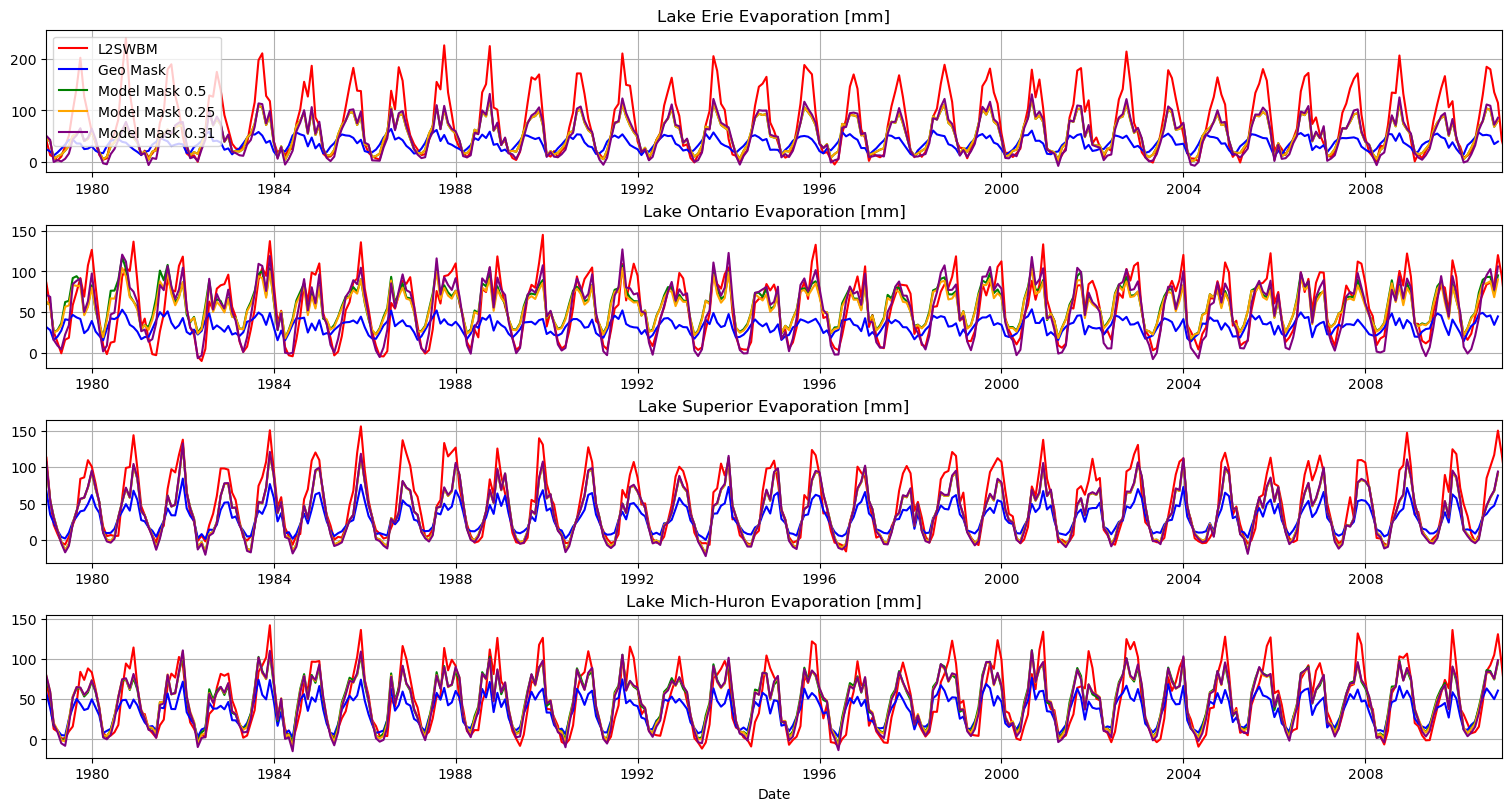

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15,8), constrained_layout=True)
axes = axes.flatten()

# Set x-axis limit to only show a specific date range
start_date = '1979-01-01'
end_date = '2010-12-31'

# Plot each dataset separately
axes[0].plot(eri_evap.index, eri_evap['Median'], label='L2SWBM', color='red')
axes[0].plot(data_geo.index, data_geo['WaterErie'], label='Geo Mask', color='blue')
axes[0].plot(data_geo.index, data_cfsr_5['eri_lake'], label='Model Mask 0.5', color='green')
axes[0].plot(data_geo.index, data_cfsr_25['eri_lake'], label='Model Mask 0.25', color='orange')
axes[0].plot(data_geo.index, data_cfsr_31['eri_lake'], label='Model Mask 0.31', color='purple')
axes[0].set_title('Lake Erie Evaporation [mm]')
axes[0].set_xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))
axes[0].grid(True)
axes[0].legend()

axes[1].plot(eri_evap.index, ont_evap['Median'], label='L2SWBM', color='red')
axes[1].plot(data_geo.index, data_geo['WaterOntario'], label='Geo Mask', color='blue')
axes[1].plot(data_geo.index, data_cfsr_5['ont_lake'], label='CFSR Mask', color='green')
axes[1].plot(data_geo.index, data_cfsr_25['ont_lake'], label='CFSR Mask', color='orange')
axes[1].plot(data_geo.index, data_cfsr_31['ont_lake'], label='CFSR Mask', color='purple')
axes[1].set_title('Lake Ontario Evaporation [mm]')
axes[1].set_xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))
axes[1].grid(True)

axes[2].plot(eri_evap.index, sup_evap['Median'], label='L2SWBM', color='red')
axes[2].plot(data_geo.index, data_geo['WaterSuperior'], label='Geo Mask', color='blue')
axes[2].plot(data_geo.index, data_cfsr_5['sup_lake'], label='CFSR Mask', color='green')
axes[2].plot(data_geo.index, data_cfsr_25['sup_lake'], label='CFSR Mask', color='orange')
axes[2].plot(data_geo.index, data_cfsr_31['sup_lake'], label='CFSR Mask', color='purple')
axes[2].set_title('Lake Superior Evaporation [mm]')
axes[2].set_xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))
axes[2].grid(True)

axes[3].plot(eri_evap.index, mih_evap['Median'], label='L2SWBM', color='red')
axes[3].plot(data_geo.index, data_geo['WaterMichHuron'], label='Geo Mask', color='blue')
axes[3].plot(data_geo.index, data_cfsr_5['mih_lake'], label='CFSR Mask', color='green')
axes[3].plot(data_geo.index, data_cfsr_25['mih_lake'], label='CFSR Mask', color='orange')
axes[3].plot(data_geo.index, data_cfsr_31['mih_lake'], label='CFSR Mask', color='purple')
axes[3].set_title('Lake Mich-Huron Evaporation [mm]')
axes[3].set_xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))
axes[3].grid(True)

plt.xlabel('Date')